In [1]:
!pip install seaborn

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installedpython
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import torch

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
files=[]
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        files.append(os.path.join(dirname, filename))
        print(os.path.join(dirname, filename))

/kaggle/input/credit-card-fraud-detection-dataset-2023/creditcard_2023.csv


In [3]:
# read data
df=pd.read_csv(files[0])
df.describe()

,id,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,568630.000000,5.686300e+05,5.686300e+05,5.686300e+05,568630.000000,5.686300e+05,5.686300e+05,568630.000000,568630.000000,568630.000000,...,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,568630.000000,5.686300e+05,5.686300e+05,568630.000000,568630.0
mean,284314.500000,-5.118237e-17,-1.023647e-16,1.023647e-16,0.000000,2.559118e-17,2.559118e-17,0.000000,0.000000,0.000000,...,1.279559e-17,1.599449e-18,6.397796e-18,-2.559118e-17,-3.838678e-17,0.000000,-2.559118e-17,3.838678e-17,12041.957635,0.5
std,164149.486121,1.000001e+00,1.000001e+00,1.000001e+00,1.000001,1.000001e+00,1.000001e+00,1.000001,1.000001,1.000001,...,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001,1.000001e+00,1.000001e+00,6919.644449,0.5
min,0.000000,-3.495584e+00,-4.996657e+01,-3.183760e+00,-4.951222,-9.952786e+00,-2.111111e+01,-4.351839,-10.756342,-3.751919,...,-1.938252e+01,-7.734798e+00,-3.029545e+01,-4.067968e+00,-1.361263e+01,-8.226969,-1.049863e+01,-3.903524e+01,50.010000,0.0
25%,142157.250000,-5.652859e-01,-4.866777e-01,-6.492987e-01,-0.656020,-2.934955e-01,-4.458712e-01,-0.283533,-0.192257,-0.568745,...,-1.664408e-01,-4.904892e-01,-2.376289e-01,-6.515801e-01,-5.541485e-01,-0.631895,-3.049607e-01,-2.318783e-01,6054.892500,0.0
50%,284314.500000,-9.363846e-02,-1.358939e-01,3.528579e-04,-0.073762,8.108788e-02,7.871758e-02,0.233366,-0.114524,0.092526,...,-3.743065e-02,-2.732881e-02,-5.968903e-02,1.590123e-02,-8.193162e-03,-0.011892,-1.729111e-01,-1.392973e-02,12030.150000,0.5
75%,426471.750000,8.326582e-01,3.435552e-01,6.285380e-01,0.707005,4.397368e-01,4.977881e-01,0.525955,0.047299,0.559262,...,1.479787e-01,4.638817e-01,1.557153e-01,7.007374e-01,5.500147e-01,0.672888,3.340230e-01,4.095903e-01,18036.330000,1.0
max,568629.000000,2.229046e+00,4.361865e+00,1.412583e+01,3.201536,4.271689e+01,2.616840e+01,217.873038,5.958040,20.270062,...,8.087080e+00,1.263251e+01,3.170763e+01,1.296564e+01,1.462151e+01,5.623285,1.132311e+02,7.725594e+01,24039.930000,1.0


In [4]:
# select input, x and true value, y
features=[col for col in df.columns if col not in ('id','Class')]
x=df[features].copy()
y=df['Class']

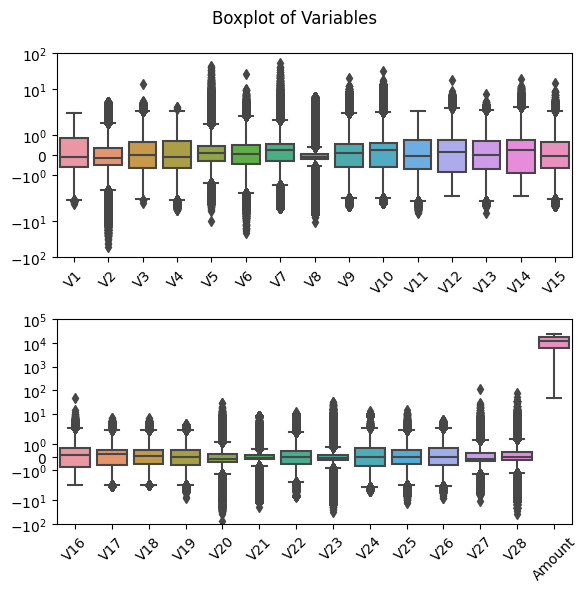

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

fig,ax=plt.subplots(ncols=1,nrows=2,figsize=(6,6))
plt.suptitle('Boxplot of Variables')
sns.boxplot(data=df[features[:15]],ax=ax[0])
sns.boxplot(data=df[features[15:]],ax=ax[1])
ax[0].set_yscale('symlog')
ax[1].set_yscale('symlog')
ax[0].set_ylim(-100,100)
ax[1].set_ylim(-100,1e5)
ax[0].tick_params('x',labelrotation=45)
ax[1].tick_params('x',labelrotation=45)
plt.tight_layout()
plt.savefig('variables_boxplot.jpg',dpi=150)


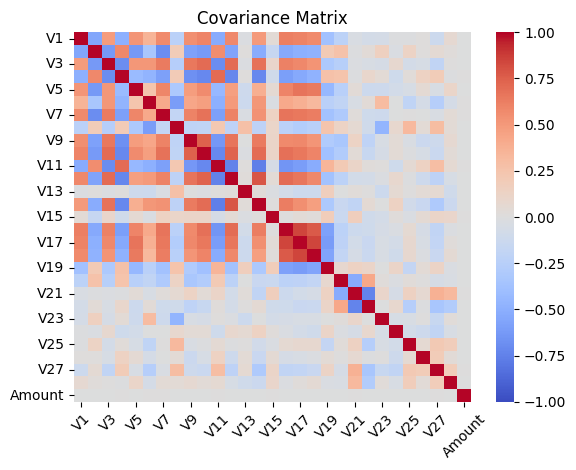

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

x_mean=x.mean()
x_std=x.std()
z=(x-x_mean)/x_std
c=z.cov()
sns.heatmap(c,cmap='coolwarm',vmax=1,vmin=-1)
plt.title('Covariance Matrix')
plt.xticks(rotation=45)
plt.savefig('covariance_matrix.jpg',dpi=150)

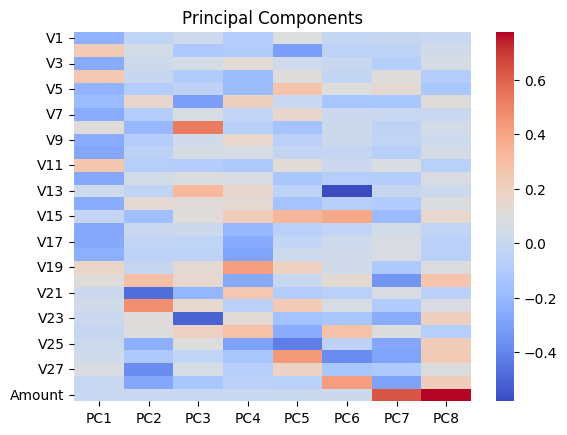

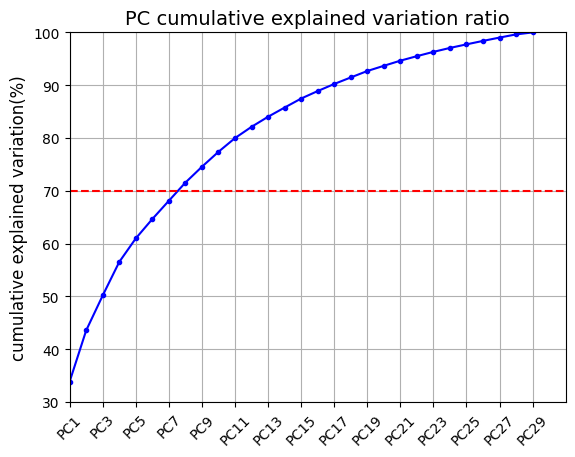

In [7]:
# PCA
eigenvalues,eigenvectors=np.linalg.eig(c)
idx=eigenvalues.argsort()[::-1]
eigenvalues=eigenvalues[idx]
eigenvectors=eigenvectors[:,idx]
explained_var_ratio=eigenvalues/np.sum(eigenvalues)
explained_var=np.cumsum(eigenvalues)/np.sum(eigenvalues)
n_components=np.argmax(explained_var>=0.7)+1
u=eigenvectors[:,:n_components]
pca_idx = np.array([f'PC{i+1}' for i in range(n_components)])
pca_component=pd.DataFrame(u,index=features,columns=pca_idx)

# project to new basis
z@pca_component

sns.heatmap(pca_component,cmap='coolwarm')
plt.title('Principal Components')
plt.savefig('PC.jpg',dpi=150)
plt.show()
plt.clf()

plt.plot(np.array(explained_var*100),'.b-')
plt.ylabel('cumulative explained variation(%)',fontsize=12)
plt.title('PC cumulative explained variation ratio',fontsize=14)
plt.hlines(y=70,xmin=0,xmax=30,color='r',linestyle='dashed')
plt.xticks(np.arange(0,30,2),[f'PC{i+1}'for i in range(0,30,2)],rotation=45)
plt.xlim(0,30)
plt.ylim(30,100)
plt.grid()
plt.savefig('pc_explained.jpg',dpi=150)
plt.show()